In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')


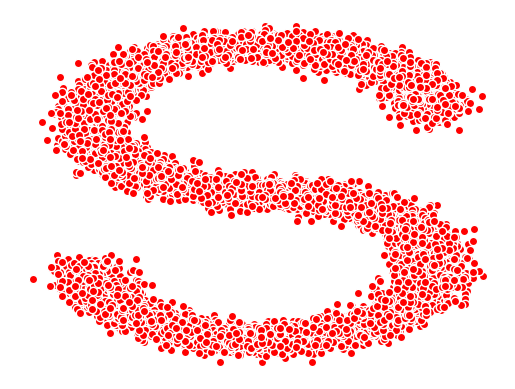

In [30]:
s_curve,_ = make_s_curve(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0

data = s_curve.T # [2,10000]
fig,ax= plt.subplots()
ax.scatter(*data,c='r',edgecolors='w')
ax.axis('off')
plt.show()

dataset = torch.Tensor(s_curve).float()

## 确定超参数的值

In [31]:
num_steps = 100
betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)
betas = betas* (5e-3-1e-5)+1e-5 #将betas张量中的每个值缩放到一个范围，这个范围是从1e-5到5e-3。
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,dim=0) # 计算累乘Cumulative product
alphas_prod_p = torch.cat([torch.tensor([1.0]),alphas_prod[:-1]],0) # p=previous
alphas_bar_sqrt = torch.sqrt(alphas_prod)

one_minus_alphas_bar_log = torch.log(1-alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape == (num_steps,)
print('all same shape:',betas.shape)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:6! (when checking argument for argument tensors in method wrapper_cat)

## 给定初始参数$x_0$和任意时刻$t$,计算$x_t$的采样值

计算公式
$$
x_t = \sqrt{\bar a_t}x_0 +\sqrt{1-\bar a_t}\epsilon

In [ ]:
def q_x(x_0,t):
    """
    扩散过程,基于x0计算出任意时刻的采样x[t]
    """
    noise = torch.randn_like(x_0) # 生成与x0同形状的随机张量(服从正态分布)
    return alphas_bar_sqrt[t]*x_0 + one_minus_alphas_bar_sqrt[t]*noise,noise
    


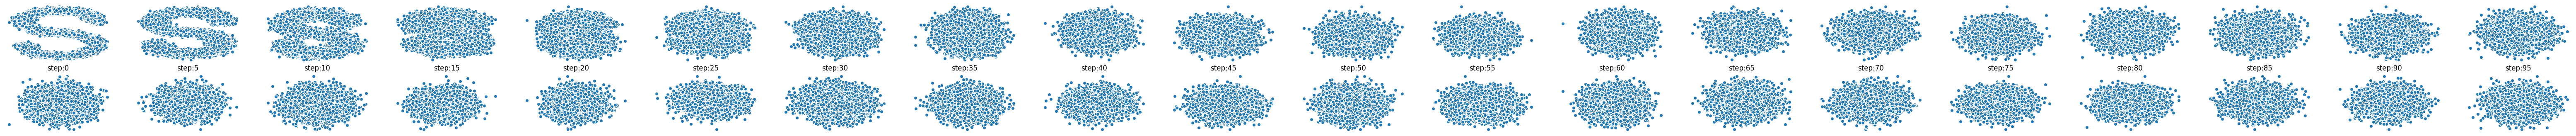

In [ ]:
# 绘制示例图
num_show = 20
q_x(dataset,50)[1].shape
fig,axs = plt.subplots(2,num_show,figsize=(80,4))
plt.rc('text',color = 'b')

for i in range(num_show):
    x_0 = dataset
    x_t,noise = q_x(x_0,i*5)
    axs[0,i].scatter(*x_t.T,edgecolors='w')
    axs[0,i].axis('off')
    axs[1,i].scatter(*noise.T,edgecolors='w')
    axs[1,i].axis('off')
    axs[1,i].set_title('step:{}'.format(i*5))

## 逆扩散过程

In [ ]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    
    def __init__(self,n_steps,num_units=128) -> None:
        super().__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2)
            ]
        )
        
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
        
    
    def forward(self,x_0,t):
        x= x_0
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        x = self.linears[-1](x)
        return x

## 误差函数
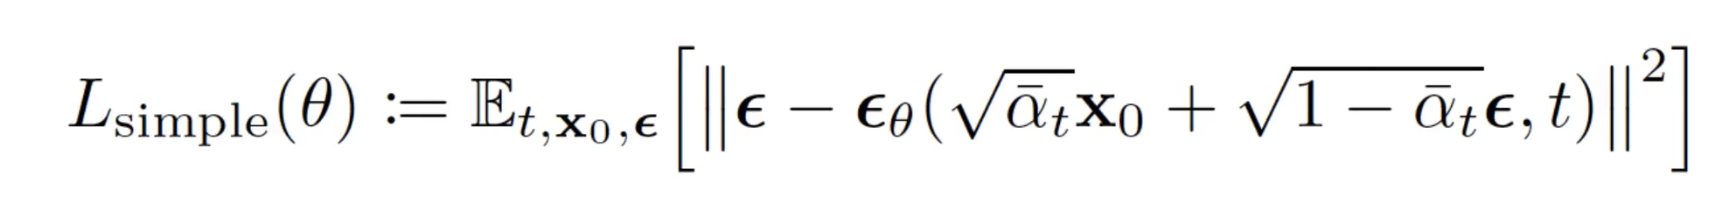

In [ ]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    """对任意时刻t进行采样计算"""
    
    batch_size = x_0.shape[0]
    
    # 对一个batchsize的样本生成随机的时刻t
    t = torch.randint(0,n_steps,size = (batch_size//2,)) # 先生成一个batchsize/2的随机数 
    y = n_steps-1-t
    t = torch.cat([t,y],dim=0) # 将t与n_steps-1-t拼接起来 目的是为了尽可能覆盖到更多的t shape= [batch_size]
    t = t.unsqueeze(-1) # shape = [batch_size,1] 升维操作
    
    
    a = alphas_bar_sqrt[t]
    am1 = one_minus_alphas_bar_sqrt[t]
    
    e = torch.randn_like(x_0) # 生成与x0同形状的随机张量(服从正态分布)
    x = x_0*a + e*am1 
    
    out = model(x,t.squeeze(-1))
    
    return (e-out).pow(2).mean()


tensor(1.1515, grad_fn=<MeanBackward0>)

## 逆扩散采样函数

In [ ]:
def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])
    coeff = betas[t]/one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x,t)
    mean = (1/(1-betas[t]))*(x-coeff*eps_theta)
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    sample = mean+sigma_t*z
    return (sample)



def p_sample_loop(model,shape,num_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]中恢复x[T-1],x[T-2]...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(num_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    
    return x_seq

## 模型训练

In [ ]:
import time
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text',color = 'blue')
model = MLPDiffusion(num_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epoch):
    start_time = time.time()
    for idx,batch in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #?
        optimizer.step()
        end_time = time.time()
    print('epoch:{},loss:{},time:{}'.format(epoch,idx,loss.item(),end_time-start_time))

    if epoch%100 == 0:
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        fig , axs = plt.subplots(1,10,figsize=(40,4))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(*cur_x.T,edgecolors='w')
            axs[i-1].set_axis_off()
            axs[i-1].set_title('step:{}'.format(i*10))
        

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:6 and cpu! (when checking argument for argument index in method wrapper__index_select)

In [7]:
# 整理的DDPM代码
from sklearn.datasets import make_s_curve
import torch
import torch.nn as nn
import time
import sys,os
sys.path.append(os.getcwd())
# from lmy import *
import matplotlib.pyplot as plt

device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

## 生成数据集
s_curve,_ = make_s_curve(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0

data = s_curve.T # [2,10000]
dataset = torch.Tensor(s_curve).float()
now_time=time.strftime("%m-%d-%H_%M_%S", time.localtime(time.time()))

# 展示图像
# fig,ax= plt.subplots()
# ax.scatter(*data,c='r',edgecolors='w')
# ax.axis('off')
# plt.show()

# 设置超参数
with torch.no_grad():
    num_steps = 100
    betas = torch.linspace(-6,6,num_steps)
    betas = torch.sigmoid(betas)
    betas = betas* (5e-3-1e-5)+1e-5 #将betas张量中的每个值缩放到一个范围，这个范围是从1e-5到5e-3。

    alphas = 1-betas
    alphas_prod = torch.cumprod(alphas,dim=0) # 计算累乘Cumulative product
    alphas_prod_p = torch.cat([torch.tensor([1.0]),alphas_prod[:-1]],0) # p=previous


    alphas_bar_sqrt = torch.sqrt(alphas_prod).to(device)
    betas=betas.to(device)
    one_minus_alphas_bar_log = torch.log(1-alphas_prod).to(device)
    one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod).to(device)


def q_x(x_0,t,one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,alphas_bar_sqrt=alphas_bar_sqrt):
    """
    扩散过程,基于x0计算出任意时刻的采样x[t]
    """
    noise = torch.randn_like(x_0) # 生成与x0同形状的随机张量(服从正态分布)
    return alphas_bar_sqrt[t]*x_0 + one_minus_alphas_bar_sqrt[t]*noise,noise
    
    
class MLPDiffusion(nn.Module):
    
    def __init__(self,n_steps,num_units=128) -> None:
        super().__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2)
            ]
        )
        
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
        
    
    def forward(self,x_0,t):
        x = x_0
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        x = self.linears[-1](x)
        return x


def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    """对任意时刻t进行采样计算"""
    
    batch_size = x_0.shape[0]
    
    # 对一个batchsize的样本生成随机的时刻t
    t = torch.randint(0,n_steps,size = (batch_size//2,)) # 先生成一个batchsize/2的随机数 
    y = n_steps-1-t
    t = torch.cat([t,y],dim=0) # 将t与n_steps-1-t拼接起来 目的是为了尽可能覆盖到更多的t shape= [batch_size]
    t = t.unsqueeze(-1) # shape = [batch_size,1] 升维操作
    t = t.to(device)
    
    a = alphas_bar_sqrt[t].to(device)
    am1 = one_minus_alphas_bar_sqrt[t].to(device)
    
    e = torch.randn_like(x_0).to(device) # 生成与x0同形状的随机张量(服从正态分布)
    x = x_0*a + e*am1 
    
    out = model(x,t.squeeze(-1))
    
    return (e-out).pow(2).mean()

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t]).to(device)
    coeff = betas[t]/one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x,t)
    mean = (1/(1-betas[t]))*(x-coeff*eps_theta)
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    sample = mean+sigma_t*z
    return (sample)



def p_sample_loop(model,shape,num_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]中恢复x[T-1],x[T-2]...x[0]"""
    cur_x = torch.randn(shape).to(device)
    x_seq = [cur_x]
    for i in reversed(range(num_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    
    return x_seq


def train():
    batch_size = 2048
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_epoch = 8000
    model = MLPDiffusion(num_steps).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    start_time = time.time()
    outs = []

    for epoch in range(num_epoch):
        for idx,data in enumerate(dataloader):
            data = data.to(device)
            loss = diffusion_loss_fn(model,data,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #?
            optimizer.step()
        if (epoch+1)%100 == 0:
            # save_model(model,dirname="MLPddpm",epoch=epoch,now_time=now_time)
            x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
            end_time = time.time()
            avg_time = (end_time-start_time)/100
            start_time = end_time
            print('epoch:{}/{},loss:{},{:.3f}s/epoch'.format(epoch+1,num_epoch,loss.item(),avg_time))
        
            outs.append(x_seq[-1].detach().T.cpu())
            if len(outs) == 5:
                _, axs = plt.subplots(1,5,figsize=(20,4))
                for i in range(5):
                    axs[i].scatter(*(outs[i]),edgecolors='w')
                    axs[i].set_axis_off()
                plt.savefig(f'output/epoch-{epoch+1}.svg',format='svg')
                plt.show()
                outs = []
                # save_image(cur_x.T.cpu(),dirname="MLPddpm",epoch=epoch,now_time=now_time)



train()